The materials herein are adopted from Qiskit text book.

In [1]:
!pip install qiskit==1.4.2
!pip install pylatexenc
!pip install qiskit_algorithms
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=488a0e6ccda00200ac45f71b01fdef38a96f99e2faf44f6e2f31fde31605f42d
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

First, let's see why you might need to move data to a higher dimension. We will create random datapoints in a circular shape, plot it in 2D, then move the data to 3D and plot it.

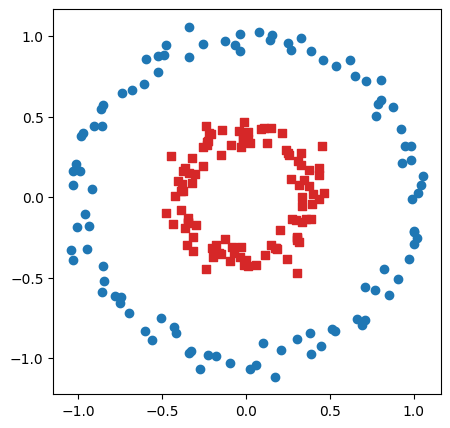

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

# Create circles dataset
X, Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()

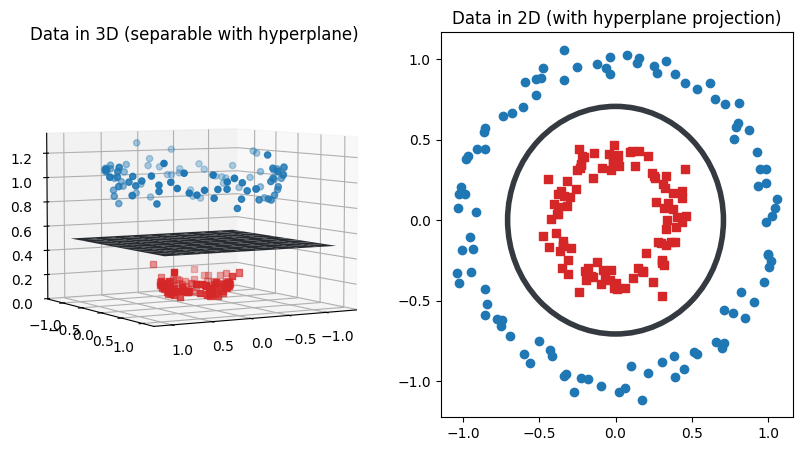

In [3]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x,y) for
               x,y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x,y)
               for x,y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s',
           c='C3')  # make red
ax.view_init(5, 60)

x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#343A3F')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='C3')  # make red

ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='#343A3F'))

plt.show()

Next, we will see how to calculate quantum kernels. We will use an adhoc dataset.

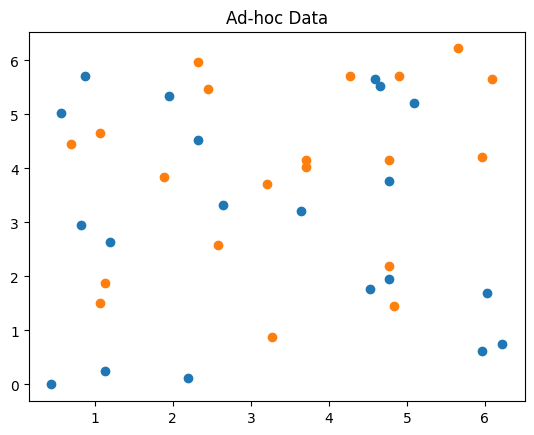

In [4]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False, plot_data=True))

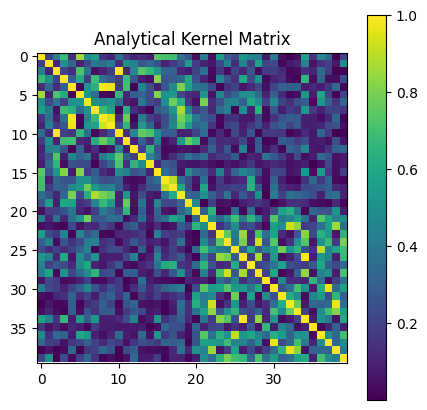

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import Statevector

def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.

        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """

    if y_data is None:
        y_data = x_data

    # List of circuits for x and y data points
    x_circuits = []
    for x in x_data:
        circuit = feature_map.assign_parameters({param: val for param, val in zip(feature_map.parameters, x)})
        x_circuits.append(circuit)

    y_circuits = []
    for y in y_data:
        circuit = feature_map.assign_parameters({param: val for param, val in zip(feature_map.parameters, y)})
        y_circuits.append(circuit)

    # Compute kernel matrix by evaluating the conjugate inner product between x and y circuits
    kernel = np.zeros((len(x_data), len(y_data)))

    for i, x_circ in enumerate(x_circuits):
        x_state = Statevector.from_instruction(x_circ)
        for j, y_circ in enumerate(y_circuits):
            y_state = Statevector.from_instruction(y_circ)
            kernel[i, j] = np.abs(x_state.inner(y_state))**2

    return kernel


# Example feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

# Calculate the kernel
kernel = calculate_kernel(adhoc_feature_map, train_data)

# Plot the kernel matrix
plt.figure(figsize=(5, 5))
plt.imshow(kernel, interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.colorbar()
plt.show()


In [6]:
from qiskit.circuit.library import ZZFeatureMap
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

To run QSVM, we will calculate the quantum kernels for the train and test data

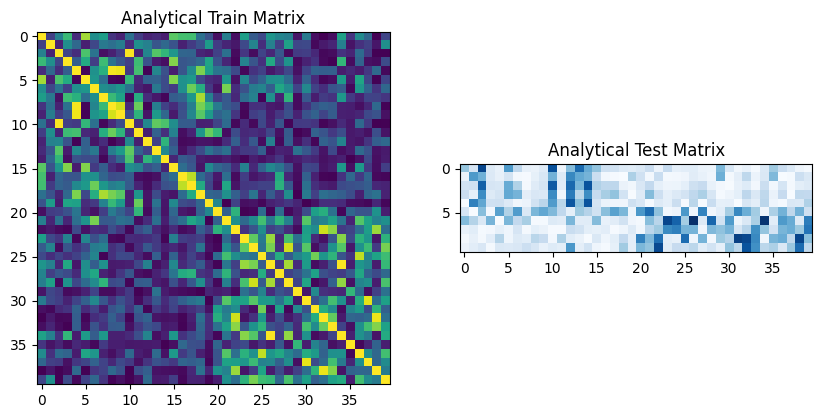

In [7]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, test_data, train_data)

# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

Now, we use these kernels in the classical SVM model. First, we train (fit) the model then we use it on test data.

In [8]:
from sklearn.svm import SVC

# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
# test svm model
model.score(test_kernel, test_labels)

1.0

There is already a built-in function in qiskit to calculate the quantum kernel. You can use this in your assignment.

In [9]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
# Create the quantum kernel
adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

# Set the SVC algorithm to use our custom kernel
model2 = SVC(kernel=adhoc_kernel.evaluate)
model2.fit(train_data, train_labels)
model2.score(test_data, test_labels)

1.0

Let's compare this to a classical SVM with classical kernel

In [10]:
model3 = SVC()
model3.fit(train_data,train_labels)
# test svm model
model3.score(test_data, test_labels)

0.3